# Information Retrieval - Corpus Filtering  
This notebook retrieves abstracts relevant to pandemics and then uses topic modeling to analyze the chosen abstracts.  Two info retrieval techniques are used: Literal Term Matching and Latent Semantic Indexing.  These are linear algebra techniques.  
We use the Scikit-Learn library.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS

/home/kjl5t/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# pull in data

# full corpus
df = pd.read_pickle("../../data/prd/Federal_RePORTER/FR-cleaned-2021FEB24.pkl")
#df = pd.read_pickle("/home/kjl5t/dspg21RnD/data/dspg21RnD/smaller-final-dataset.pkl")

# pandemics corpus
#df = pd.read_pickle("pandemic_corpus.pkl")
#df.reset_index(inplace = True)
#df.rename(columns={'index':'original index'}, inplace=True)

In [3]:
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,0,17608,152242,The multiprotein complex y-secretase proteolyt...,2008,1,1,The multiprotein complex y-secretase proteolyt...,T,1402,g,"[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y-secretase, proteolyt...","[multiprotein, complex, y_secretase, proteolyt...","[multiprotein, y_secretase, proteolytically_cl...",Active Sites; Affect; Alzheimer's Disease; Am...,STRUCTURE OF SIGNAL PEPTIDE PEPTIDASE,HHS,NIH,NIA,5F32AG027647-03,12/1/2005,1/1/2008,"LIEBERMAN, RAQUEL L",NaN,07,030811269,BRIGHAM AND WOMEN'S HOSPITAL,BOSTON,MA,021156110,UNITED STATES,12/1/2007,1/1/2008,93.866,2008,3483.0,NaN
1,1,111864,190316,DESCRIPTION (provided by applicant): The Kis...,2008,1,1,The Kissl gene encodes peptides called kisspep...,T,2553,y,"[Kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, call, kisspepti...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...","[kissl, gene, encode, peptide, kisspeptin, bin...",Affect; Animal Model; Axon; Behavior; Behavio...,ROLE OF KISS1 NEURONS IN THE SEASONAL AND CIRC...,HHS,NIH,NICHD,5K99HD056157-02,9/1/2007,1/1/2009,"KAUFFMAN, ALEXANDER S",NaN,07,605799469,UNIVERSITY OF WASHINGTON,SEATTLE,WA,981959472,UNITED STATES,9/1/2008,1/1/2009,93.865,2008,39175.0,NaN
2,2,22052,154213,DESCRIPTION (provided by applicant): The objec...,2008,1,1,The objective of this research is to understan...,T,1414,e,"[objective, research, be, understand, biophysi...","[objective, research, be, understand, biophysi...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[objective, research, understand, biophysical,...","[biophysical, basis, thermodynamics_kinetic, m...",Agreement; Antibodies; base; Binding; Biochem...,CARBONIC ANHYDRASE AS A MODEL TO UNDERSTAND DI...,HHS,NIH,NIGMS,5F32GM076971-02,1/2/2007,1/1/2009,"MACK, ERIC T",NaN,05,082359691,HARVARD UNIVERSITY,CAMBRIDGE,MA,021385319,UNITED STATES,1/2/2008,1/1/2009,93.859,2008,49646.0,NaN
3,3,35004,159362,Obesity is the cause of many adverse pregnancy...,2008,1,1,Obesity is the cause of many adverse pregnancy...,O,1545,d,"[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, many, adverse, pregnancyoutco...","[obesity, cause, adverse, pregnancyoutcome, re...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, cause, adverse_pregnancyoutcome, res...","[obesity, adverse_pregnancyoutcome, great, hea...",African; Analysis of Variance; Asians; Birth;...,OBESITY ON VAGAL TONE AND HBA1C DURING PREGNANCY,HHS,NIH,NINR,5F31NR009611-03,4/1/2006,1/1/2009,"HELMREICH, REBECCA J",NaN,09,800771594,UNIVERSITY OF TEXAS HLTH SCI CTR HOUSTON,HOUSTON,TX,770305400,UNITED STATES,4/1/2008,1/1/2009,93.361,2008,20406.0,NaN
4,4,371628,594482,Local potato advisory groups have expressed in...,2010,1,1,Local potato advisory groups have expressed in...,L,271,s,"[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, group, express, inte...","[local, potato, advisory, express, interest, m...",cost; Health; interest; Manure; Parasitic nem...,PLANT-PA

In [4]:
# input needed for doc-term matrix creation in Scikit-Learn is one string per document (not a list of strings).  
# Original data 'ABSTRACT' is already in this form, but not the tokens in "final_frqwds_removed"


tokens = df["stopwds_removed"]

docs = [] # docs will contain the processed tokens in string form (1 string per abstract)

for abstract in tokens:
    docs.append(" ".join(abstract))
    
docs = pd.Series(docs)


#docs = df["ABSTRACT"]  # raw text


### Term Matching

In [5]:
# new approach to grab all "artificial intelligence" matches

term_match_idx = []

for i, abstract in enumerate(docs):
    if ('artificial intelligence' in abstract): 
        term_match_idx.append(i)

# stopwds_removed
# artificial intelligence: 936
# artificialintelligence: 26
# artificial intelligent: 11
# artificially intelligent: 23
# artificialintelligent: 1
# machine learning: 4933
# machine learn: 5729
# natural language processing: 924
# natrual language process: 929

# final_tokens
# artificial_intelligence: 929
# artificial intelligence: 11 (typos and other misses)

In [6]:
len(term_match_idx) 

936

### Helper Functions

In [7]:
# Create binary query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [8]:
def return_top_abstracts(scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if top_n = -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        n = sum(scores > 0)
        ix = scores_sorted_idx[:n]
    else:
        ix = scores_sorted_idx[:top_n]
    
    #print(ix[0:10])
    
    return ix
    

In [9]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

## Latent Semantic Indexing (LSI)

In [10]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer(min_df=20)
tf_idf = tf_idf_vectorizer.fit_transform(docs)

tf_idf_terms = tf_idf_vectorizer.get_feature_names()

In [11]:
len(tf_idf_terms)

73069

In [12]:
# CHANGE QUERY WORDS HERE

#query_words = []

#for word in tf_idf_terms:
#    if 'artificial' in word:
#        query_words.append(word)

query_words = ['artificial', 'intelligence', 'artificialintelligence'] 
              
q = create_query(query_words, tf_idf_terms)

In [13]:
query_words

['artificial', 'intelligence', 'artificialintelligence']

In [14]:
# Find the Truncated SVD of the TF-IDF matrix

lsa = TruncatedSVD(n_components=200, random_state=1)  # CHANGE THE NUMBER OF COMPONENTS - NOTE: MORE COMPONENTS 
                                                      # GIVES YOU A MORE ACCURATE APPROXIMATION OF THE DOC-TERM 
                                                      # MATRIX, BUT IS ALSO MORE EXPENSIVE AND MAY NOT LEAD TO THE 
                                                      # BEST INFO RETRIEVAL RESULTS.
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [15]:
S = lsa.singular_values_

In [16]:
S

array([131.42846235,  78.29545617,  59.26293043,  55.84475786,
        54.83924446,  50.97456289,  47.30147997,  44.1971259 ,
        41.68739349,  39.97459184,  39.56049829,  38.48671512,
        37.4524683 ,  36.17823385,  35.17781792,  34.93699223,
        34.01217915,  33.45551366,  33.04308953,  32.81267613,
        32.0278632 ,  31.9092402 ,  31.3118951 ,  31.18539203,
        30.69563793,  30.30047961,  30.18320173,  29.7931936 ,
        29.72104976,  29.60957144,  29.04418432,  28.62677431,
        28.14549119,  28.07848655,  27.70651087,  27.4544931 ,
        27.30376101,  27.210167  ,  27.11309153,  27.05092339,
        27.01906518,  26.72692633,  26.51392904,  26.41814337,
        26.34008856,  26.18801876,  26.04519203,  25.88175087,
        25.84763195,  25.79697347,  25.70938429,  25.5061714 ,
        25.38482374,  25.28334793,  25.02085471,  24.8806723 ,
        24.68355814,  24.46641436,  24.40113355,  24.37313529,
        24.27778064,  24.25327769,  24.04940599,  23.99

In [17]:
# transform query to be in same space as documents

q = q.reshape(1,-1)  # changes (n,) vector to (1,n)
qhat = lsa.transform(q)

In [18]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 200)
(690814, 200)
(200, 73069)


In [19]:
lsa_scores = cosine_similarity(qhat, USigma)  

In [20]:
sum(lsa_scores[0] > 0)

# 50: 518954
# 100: 486165
# 150: 480029
# 200: 473396 
# 500: 445744

473396

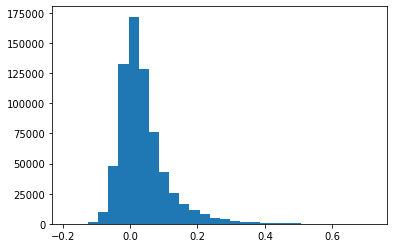

In [21]:
plt.hist(lsa_scores[0], bins = 30);
#plt.xlim(0.9, 1.1)

In [22]:
#np.percentile(lsa_scores[0], 93)

sum(lsa_scores[0] >= 0.5) # len(lsa_scores[0])

# 50: 16210
# 100: 2857
# 150: 1015
# 200: 703
# 500: 15

703

In [23]:
lsa_idx = return_top_abstracts(lsa_scores[0], 3000)  # CHANGE NUMBER OF TOP DOCS RETURNED
top_lsa_abstracts = docs[lsa_idx]

# top scores
lsa_scores[0][lsa_idx][0:10]

array([0.71775819, 0.7035631 , 0.69959444, 0.69776959, 0.69685481,
       0.69253468, 0.68933348, 0.68715914, 0.68613186, 0.68315753])

In [24]:
top_lsa_abstracts[0:50]

689263    learn algorithm pervasively deploy robotic sys...
456658    learn robot behavior large data set important ...
627918    goal project develop machine learning algorith...
611795    machine learning science design computational ...
675385    project develop technique efficient incrementa...
509794    project develop groundwork system allow large ...
645307    robot task environment complex challenging pro...
84714     goal project allow human assist machine learn ...
63555     currently surge interest service robotics desi...
509380    virtual agent physical robot common increase n...
643591    machine learning algorithm increasingly everyd...
82414     past year machine learning algorithm especiall...
108334    project consider problem apprenticeship learn ...
627420    new security exploit emerge far faster manual ...
642224    remote control robot potential allow human per...
683102    broader impact commercial potential small busi...
633822    project develop new method use

In [25]:
top_lsa_abstracts.iloc[800]

'ever- increase number mobile application use deep learning model provide novel useful feature language translation object recognition feature support pass input data example photo audio clip complex model order generate meaningful output mobile application use deep learning model currently need choose prediction accuracy speed development time lead poor user experience reason run state art model older mobile device propose modi mobile deep inference project outline new research design implement mobile aware deep inference platform combine innovation algorithm system optimization propose work address mobile deep inference performance problem enable flexible fine grain model partition layer base inference execution mobile model design modi enable scalable mobile deep inference paradigm efficient model management device cloud project empower deep learning provide useful feature mobile application significantly improve performance consequently project open door allow run optimize deep lea

#### Scratch work for choosing rank of Truncated SVD in LSI

In [26]:
print(len(set(lsa_idx[0:936]) - set(term_match_idx)))  # worst possible: 936

# 50: 890
# 100: 877
# 150: 853
# 200: 853 
# 500: 844

len(set(term_match_idx).intersection(set(lsa_idx[:936])))

853


83

In [28]:
#idx_50 = lsa_idx
#idx_100 = lsa_idx
#idx_150 = lsa_idx
#idx_200 = lsa_idx
#idx_500 = lsa_idx

In [57]:
idx_50[0:50]

array([235896,  49442, 578917, 520638, 636134, 386435, 360906, 214643,
       684048, 685888, 684153, 627420, 613355, 627735, 515214, 516548,
       609262, 628826, 510510, 628668, 546712, 686073, 603468, 513537,
       624932, 624933, 252415, 622160, 533250, 512383, 510998, 503154,
       523438, 112648, 580395, 475248, 595235, 633889, 243916, 445294,
       243929, 524895, 683102, 531779, 633822, 618752, 675385, 564004,
       483551, 618597])

In [72]:
idx_100[0:50]

array([509794, 515214, 516548, 675385, 473620, 689263, 633889, 617179,
       520638, 456658, 642215, 386435, 510998, 512383, 678689, 627918,
       627420, 526852, 484124, 686119, 685943, 675290, 638728, 638659,
       627104, 509380, 109800, 555368, 294655, 642224, 106248, 571551,
        70629,  84714, 611795, 294658, 533250, 533649, 509467, 576029,
       595735, 637041, 642643, 634007, 526880,  77931, 369320, 645307,
       112556, 628725])

In [87]:
idx_150[0:50]

array([675385, 627918, 509794, 456658, 689263, 515214, 516548, 686119,
       685943, 627420, 520638, 509380, 645307, 109800, 378785, 509467,
       642224, 294655,  84714, 642215, 675638, 595735, 526852, 294658,
       288887, 683102, 445294, 637041, 611795, 627104, 685095, 363305,
       108334, 484124, 627059, 369320, 386435, 634007,  82414, 643591,
       628725, 533649, 524895, 665021, 628826, 555368, 362676, 642602,
        26088, 567032])

In [29]:
idx_200[0:50]

array([689263, 456658, 627918, 611795, 675385, 509794, 645307,  84714,
        63555, 509380, 643591,  82414, 108334, 627420, 642224, 683102,
       633822, 515214, 516548, 665021,  84844, 378785, 637041, 509467,
       109800, 558789, 685095, 360440, 642215, 634007, 531425, 519846,
       519833, 676755,  26869, 520638, 445294, 266656, 675638, 612478,
        83804, 533649, 288887, 369320, 544059, 544405, 511437, 400148,
       363305, 567032])

In [120]:
idx_500[0:50]

array([109800, 689263,  63555, 456658, 643591, 627918, 524895, 112433,
       544059, 544405, 627420, 683102, 689160, 363802, 510850,  84714,
        82414, 611795, 531425, 360440, 235896, 378785, 516548, 515214,
        83804, 477862, 685095, 232473, 509794, 645307,  26088, 675638,
       564692, 634007, 614897, 665021, 679808, 532824, 595285, 321163,
       637041, 552214, 484124, 685934, 294655, 337761, 338740, 494941,
        26869, 386435])

In [119]:
#pickle.dump([idx_50, idx_100, idx_150, idx_200, idx_500], open('ai-rank_test.sav','wb'))

In [ ]:
# import saved data
f = open('rank_test.sav', 'rb')
[idx_50, idx_100, idx_150, idx_200, idx_500] = pickle.load(f)
f.close()

In [121]:
print(len(set(idx_50[0:999]) - set(idx_100[0:999]))) 

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_100[0:1999]))) 

453
--------
805


In [122]:
print(len(set(idx_50[0:999]) - set(idx_150[0:999])))
print(len(set(idx_100[0:999]) - set(idx_150[0:999])))

print('------------')

print(len(set(idx_50[0:1999]) - set(idx_150[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_150[0:1999])))

562
268
------------
1083
530


In [123]:
print(len(set(idx_50[0:999]) - set(idx_200[0:999])))
print(len(set(idx_100[0:999]) - set(idx_200[0:999])))
print(len(set(idx_150[0:999]) - set(idx_200[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_200[0:1999])))

639
394
205
--------
1238
747
441


In [124]:
print(len(set(idx_50[0:999]) - set(idx_500[0:999])))
print(len(set(idx_100[0:999]) - set(idx_500[0:999])))
print(len(set(idx_150[0:999]) - set(idx_500[0:999])))
print(len(set(idx_200[0:999]) - set(idx_500[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_200[0:1999]) - set(idx_500[0:1999])))

697
463
338
310
--------
1344
918
681
556


In [151]:
lsa_scores[0][lsa_idx][702]

0.5000082957556983

In [125]:
# check overlap for the documents returned with cosine score > 0.5

# sum(lsa_scores[0] >= 0.5) 

# 50: 16210
# 100: 2857
# 150: 1015
# 200: 703
# 500: 15

print(len(set(idx_150[0:1015]) - set(idx_200[0:703])))
print(len(set(idx_150[0:1015]) - set(idx_500[0:15])))
print(len(set(idx_200[0:703]) - set(idx_500[0:15])))

print('--------')

print(len(set(idx_150[0:1015]).intersection(set(idx_200[0:703]))))
print(len(set(idx_150[0:1015]).intersection(set(idx_500[0:15]))))
print(len(set(idx_500[0:15]).intersection(set(idx_200[0:703]))))

373
1000
688
--------
642
15
15


## Create filtered corpus

We use the results of our two information retrieval techniques to create a new, smaller corpus that only contains abstracts relevant to the query. 

In [30]:
docs_ix = np.concatenate([term_match_idx, lsa_idx[:703]]) 

In [31]:
docs_idx = np.unique(docs_ix)

In [32]:
docs_idx.shape

(1569,)

**create case-study corpuses**

In [33]:
filt_corpus = df.loc[docs_idx, :]

In [34]:
filt_corpus.shape

(1569, 40)

In [35]:
filt_corpus.to_pickle("./ai_corpus.pkl")

#pandemic_corpus = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
#pandemic_corpus.shape

In [36]:
lim_docs = filt_corpus["final_frqwds_removed"]

In [37]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [38]:
len(lim_docs)

1569

## Topic Modeling with relevant pandemic abstracts

In [39]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [40]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP
nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True) #, max_features=int(len(lim_docs)/2))

nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [41]:
nmf_tf_idf.shape

(1569, 5629)

In [42]:
# topic modeling with NMF

nmf_model = NMF(n_components=30, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [43]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('machine_learning', 3.1740800784574352)
('machine', 1.3734485046737714)
('learn', 1.257595489039766)
('statistical', 0.7326558920406767)
('prediction', 0.6836755941164422)
('framework', 0.5342171579229603)
('feature', 0.511903677688454)
('domain', 0.45434412035364924)
('scale', 0.447706988232282)
('representation', 0.437348590766556)

Topic 1:
('robot', 1.9103756719289942)
('environment', 0.2403028384771644)
('people', 0.16515356390454364)
('soft', 0.15102555733383377)
('robotics', 0.148887590393513)
('team', 0.1454574837651478)
('human', 0.13927674845976162)
('interaction', 0.13034737112627828)
('motion', 0.126469719390865)
('planning', 0.12169923435912505)

Topic 2:
('conference', 1.175315596311104)
('doctoral', 0.7576592763408715)
('student', 0.6719995190832855)
('consortium', 0.6098627552430603)
('participant', 0.408054276728099)
('international', 0.3819266421578622)
('travel', 0.24367776092377452)
('participation', 0.24027077020774848)
('hold', 0.23153120416195616)
('se

In [44]:
# TRY TOPIC MODELING WITH LDA
# create document-term matrix

lda_vectorizer = CountVectorizer(max_df=1.0, min_df=3, lowercase=True)
lda_dtm = lda_vectorizer.fit_transform(text)

In [45]:
# create model

num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=39, random_state = 0)
doc_top_dist = lda_model.fit_transform(lda_dtm)
top_term_dist = lda_model.components_

In [46]:
print_topics(lda_model, lda_vectorizer, 10)


Topic 0:
('brain', 221.84305860476837)
('image', 171.4705037297174)
('imaging', 148.44798933360082)
('clinical', 122.57583154422755)
('patient', 116.63146898530947)
('cancer', 116.3686187471945)
('tissue', 75.62843547012453)
('biomedical', 73.96103360158449)
('dr', 69.35676025478287)
('tumor', 69.02694996057585)

Topic 1:
('student', 748.8527856359768)
('conference', 449.5678061474341)
('participant', 217.62485144125645)
('workshop', 207.3118399895346)
('science', 196.77905688698817)
('computer', 150.14622579547648)
('artificial_intelligence', 145.16177557338122)
('computational', 141.07847286973004)
('consortium', 135.09965478449533)
('graduate', 134.85572812510236)

Topic 2:
('algorithm', 999.1100938691992)
('machine_learning', 634.2563462118017)
('learn', 599.6854151500369)
('task', 450.2967491917475)
('learning', 415.85417817600273)
('domain', 273.26124569418755)
('computer', 256.46730717527686)
('framework', 234.52710173042865)
('machine', 223.41696027861238)
('optimization', 221

In [47]:
filt_corpus.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
206,206,1094356,1130812,PROJECT SUMMARY / ABSTRACTModern digital patho...,2019,1,1,Modern digital pathology departments produce a...,M,3058,e,"[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, treme...",actionable mutation; anticancer research; Arc...,GENOTYPE AND HISTOLOGICAL PHENOTYPE RELATIONSH...,HHS,NIH,NCI,5F31CA214029-03,1/11/2017,1/10/2020,"SCHAUMBERG, ANDREW JAMES",NaN,12,060217502,WEILL MEDICAL COLLEGE OF CONRELL UNIVERSITY,NEW YORK,NY,100654805,UNITED STATES,1/11/2019,1/10/2020,93.398,2019,45016.0,NaN
207,207,938623,931185,PROJECT SUMMARY / ABSTRACTModern digital patho...,2017,1,1,Modern digital pathology departments produce a...,M,3059,e,"[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, produ...","[modern, digital, pathology, department, treme...",actionable mutation; anticancer research; Arc...,GENOTYPE AND HISTOLOGICAL PHENOTYPE RELATIONSH...,HHS,NIH,NCI,1F31CA214029-01,1/11/2017,1/10/2020,"SCHAUMBERG, ANDREW JAMES",NaN,12,060217502,WEILL MEDICAL COLLEGE OF CONRELL UNIVERSITY,NEW YORK,NY,100654805,UNITED STATES,1/11/2017,1/10/2018,93.398,2017,44044.0,NaN
2940,2940,197954,119775,This is funding to support participation by ap...,2009,1,1,This is funding to support participation by ap...,T,3170,e,"[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, support, participation, approximately, ...","[fund, participation, approximately, graduate,...",Academia; Artificial Intelligence; Arts; base...,SUPPORTING STUDENTS ATTENDING IUI 2009 CONFERENCE,NSF,NSF,NaN,0914591,2/1/2009,1/31/2010,"WELD, DANIEL S",NaN,07,605799469,UNIVERSITY OF WASHINGTON,SEATTLE,WA,98195-9472,UNITED STATES,NaN,NaN,47.070,2009,3459.0,NaN
2988,2988,197569,119389,Within the literature on causal statistical in...,2009,1,1,Within the literature on causal statistical in...,W,4672,t,"[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, c...",Affect; Agriculture; Applied Research; Area; ...,COLLAB. PROPOSAL: PARTIAL AND POINT IDENTIFICA...,NSF,NSF,NaN,0852139,2/15/2009,1/31/2010,"FLORES-LAGUNES, ALFONSO",NaN,06,019361885,UNIVERSITY OF FLORIDA,GAINESVILLE,FL,32611-2002,UNITED STATES,NaN,NaN,47.075,2009,63287.0,NaN
3035,3035,197568,119388,Within the literature on causal statistical in...,2009,1,1,Within the literature on causal statistical in...,W,4714,t,"[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, i...","[literature, causal, statistical, inference, c...",A